# Wstęp

**Celem projektu była analiza i porównanie skuteczności modeli sieci neuronowych w zadaniu automatycznej klasyfikacji sarkazmu w nagłówkach tekstowych.**

W projekcie wykorzystano publiczny zbiór danych **Sarcasm Headlines Dataset**, zawierający nagłówki wiadomości oznaczone jako sarkastyczne lub nie.
Przeprowadzono wstępną analizę danych i ich wizualizację, a następnie przygotowano dane za pomocą warstwy TextVectorization, która umożliwiła efektywną konwersję tekstu na wektory liczbowe.

W części modelowania zbudowano dwa złożone modele neuronowe:

- **BiGRU** (Bidirectional Gated Recurrent Unit) - model sekwencyjny analizujący kontekst w obu kierunkach.

- **BiLSTM + Attention** - model oparty na warstwach LSTM wzbogacony o mechanizm Attention, który pozwala skupić się na najważniejszych fragmentach tekstu.

W projekcie oceniono również wpływ takich technik jak waga klas (class_weight), BatchNormalization, Dropout czy dobór optymalizatora (Adam, RMSprop) na stabilność i jakość uczenia modeli.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab import files
import seaborn as sns
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import layers, Sequential, regularizers
from sklearn.metrics import classification_report, confusion_matrix

# Pobranie i wizualizacja danych

In [2]:
# Wgranie i załadowanie, wcześniej pobranego z kaggle, pliku Sarcasm_Headlines_Dataset_v2.json z komputera
uploaded = files.upload()

Saving Sarcasm_Headlines_Dataset.json to Sarcasm_Headlines_Dataset.json


Załadowany powyżej plik JSON zawiera dane pochodzące z nagłówków artykułów informacyjnych, które zostały oznaczone pod kątem obecności sarkazmu. Każdy rekord zawiera tekst nagłówka (headline), etykietę (is_sarcastic) wskazującą, czy nagłówek jest sarkastyczny (1) czy nie (0), oraz opcjonalny link do pełnego artykułu (article_link).

In [3]:
# Odczytanie plikuw z danymi
filename = "Sarcasm_Headlines_Dataset.json"
df = pd.read_json(filename, lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Na wykresie rozkładu klas widzimy, że dane są trochę niezbilansowane. Liczba nagłówków nie-sarkastycznych (klasa 0) jest większa niż nagłówków sarkastycznych (klasa 1).

- Klasa "Nie-sarkazm" (0): ok. 15 000 przykładów

- Klasa "Sarkazm" (1): ok. 11 500 przykładów

Różnica między klasami nie jest drastyczna, ale wystarczająca, by uwzględnić ją przy trenowaniu modelu, np. przez:

- **użycie metryki F1-score zamiast samej accuracy**. Accuracy (dokładność) mierzy tylko ogólny procent poprawnych predykcji. Np: jeśli 60% danych to klasa 0 (nie-sarkazm), model przewidujący zawsze „0” osiągnie accuracy = 60%, mimo że nigdy nie rozpozna sarkazmu (klasa 1). F1-score uwzględnia zarówno precyzję (czy model się nie myli, gdy mówi "sarkazm") oraz czułość/recall (potrafi odpowiednio rozpoznać jak najwięcej nagłówków, które naprawdę są sarkastyczne).

- **zastosowanie wag klas (class_weight) podczas trenowania modelu**. Dzięki temu model uczy się traktować pomyłki na rzadkiej klasie jako bardziej znaczące, co zwiększa jego szansę na poprawne rozpoznawanie mniej licznych przypadków.

- **rozważenie przetwarzania danych (np. undersampling/oversampling), jeśli model będzie miał problem z generalizacją.** Dane można poprawić np. zmniejszając liczbę przykładów klasy dominującej (undersampling) albo zwiększając liczbę przykładów klasy rzadkiej (oversampling), żeby model miał szansę lepiej nauczyć się obu klas.

<ipython-input-4-7c03e16a3b10>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


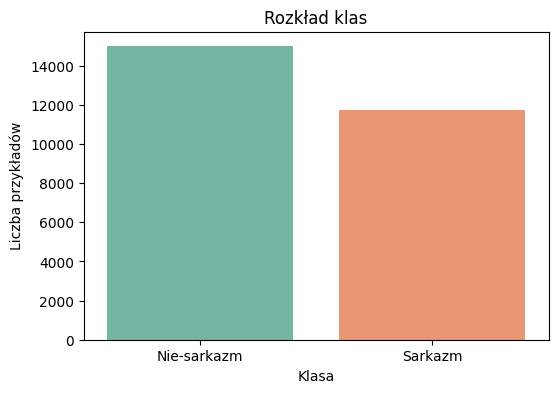

In [4]:
# Wybieramy tylko potrzebne kolumny ('headline' i 'is_sarcastic') oraz zmieniamy ich nazwy ('text' i 'label')
df = df[['headline', 'is_sarcastic']].rename(columns={'headline': 'text', 'is_sarcastic': 'label'})

# Rozkład klas
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='Set2')
plt.xticks([0, 1], ['Nie-sarkazm', 'Sarkazm'])
plt.title("Rozkład klas")
plt.xlabel("Klasa")
plt.ylabel("Liczba przykładów")
plt.show()

In [5]:
"""
Czyścimy dane towrząc nową kolumnę, która zawiera tekst nagłówków, gdzie:
- zamieniamy wszystkie litery na małe
- usuwamy linki
- usuwamy znaki interpunkcyjne
- usuwamy cyfry
"""
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

df['clean_text'] = df['text'].apply(clean_text)

df.head()

,text,label,clean_text
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sues over secret bl...
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catches up to our thorny ...
2,mom starting to fear son's web series closest ...,1,mom starting to fear sons web series closest t...
3,"boehner just wants wife to listen, not come up...",1,boehner just wants wife to listen not come up ...
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wishes snape happy birthday in the ...


Większość nagłówków ma długość od 6 do 13 słów. Rozkład ma kształt zbliżony do rozkładu normalnego z lekkim ogonem w prawo, co oznacza, że rzadziej występują bardzo krótkie (poniżej 3 słów) lub bardzo długie (powyżej 20 słów) nagłówki.

Każdy słupek pokazuje, ile nagłówków ma długość mieszczącą się w danym zakresie liczby słów.
Np: słupek nad liczbą 10 pokazuje, ilu nagłówków ma dokładnie (lub prawie) 10 słów.

Krzywa pokazuje wygładzony przebieg rozkładu długości nagłówków. Dzięki niej łatwiej zobaczyć ogólny kształt danych (np. czy rozkład jest symetryczny, czy ma ogon z jednej strony).
Jest to estymacja tego, jak często występują różne długości, bez sztywnego podziału na przedziały jak w histogramie.

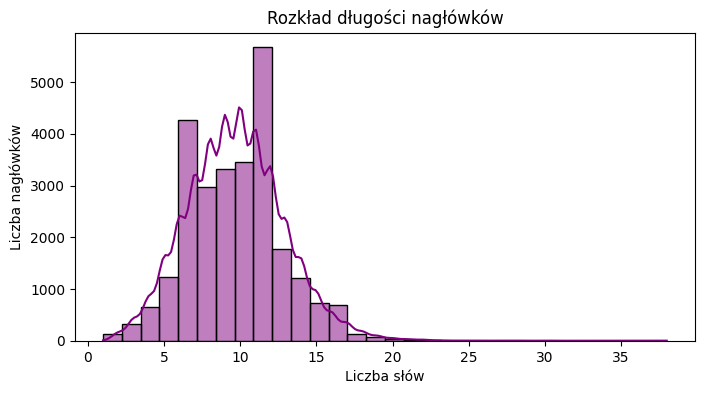

In [6]:
# Analiza długości tekstów

df['length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))
sns.histplot(df['length'], bins=30, kde=True, color='purple')
plt.title("Rozkład długości nagłówków")
plt.xlabel("Liczba słów")
plt.ylabel("Liczba nagłówków")
plt.show()

# Przetwarzanie danych

In [7]:
# Podział danych na zbiór treningowy i testowy
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

"""
test_size=0.2 - 20% danych trafia do testu, 80% do treningu

stratify=y - zachowujemy proporcje klas w obu zbiorach (sarkazm i nie-sarkazm)

random_state=42 - ustalamy losowość, żeby podział był powtarzalny (ziarno losowości)
Dzięki temu:
 - za każdym razem, gdy uruchamiamy kod, dane zostaną podzielone w dokładnie ten sam sposób,
 - pozwala to powtórzyć eksperyment z identycznym wynikiem (tzw. replikowalność).
Liczba 42 nie ma specjalnego znaczenia. Może być dowolna, ale użycie tej samej liczby zawsze da taki sam podział danych.
"""

'\ntest_size=0.2 - 20% danych trafia do testu, 80% do treningu\n\nstratify=y - zachowujemy proporcje klas w obu zbiorach (sarkazm i nie-sarkazm)\n\nrandom_state=42 - ustalamy losowość, żeby podział był powtarzalny (ziarno losowości)\nDzięki temu:\n - za każdym razem, gdy uruchamiamy kod, dane zostaną podzielone w dokładnie ten sam sposób,\n - pozwala to powtórzyć eksperyment z identycznym wynikiem (tzw. replikowalność).\nLiczba 42 nie ma specjalnego znaczenia. Może być dowolna, ale użycie tej samej liczby zawsze da taki sam podział danych.\n'

Na wykresie przedstawiono częstość występowania słów w zbiorze treningowym, uporządkowaną według częstości (od najczęstszych po najrzadsze). Widać, że liczba wystąpień słów gwałtownie spada po około 8000 najczęściej używanych słów, co zaznaczono czerwoną linią przerywaną.

Stąd wnioskujemy, że ustawienie VOCAB_SIZE = 8000 w warstwie wektoryzującej pozwala zachować najczęściej występujące i najważniejsze słowa, a jednocześnie ogranicza rozmiar słownika i złożoność modelu, co jest optymalne dla skuteczności i wydajności treningu.

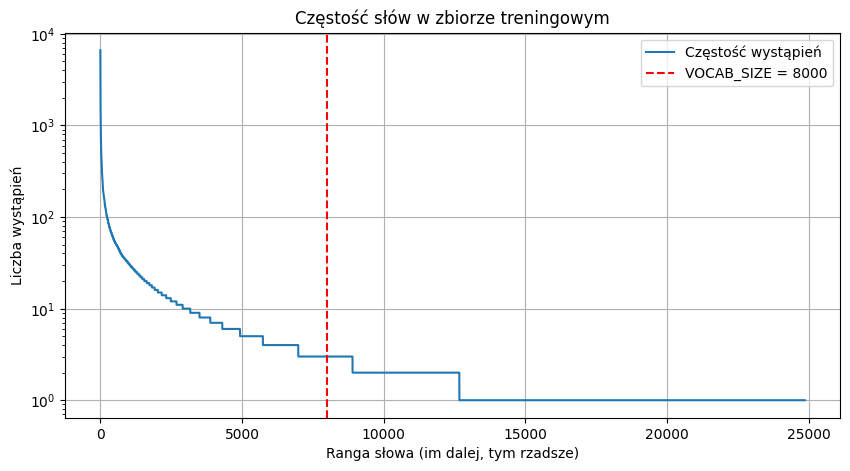

In [8]:
# Rozdzielenie wszystkich słów w zbiorze treningowym
all_words = " ".join(X_train).lower().split()
word_counts = Counter(all_words)

# Posortowana lista częstości
sorted_counts = sorted(word_counts.values(), reverse=True)

plt.figure(figsize=(10, 5))
plt.plot(sorted_counts, label='Częstość wystąpień')
plt.axvline(x=8000, color='red', linestyle='--', label='VOCAB_SIZE = 8000')  # pionowa linia pomocnicza
plt.title("Częstość słów w zbiorze treningowym")
plt.xlabel("Ranga słowa (im dalej, tym rzadsze)")
plt.ylabel("Liczba wystąpień")
plt.yscale("log")  # skala logarytmiczna dla czytelności
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Parametry wektoryzacji
VOCAB_SIZE = 8000         # Maksymalna liczba słów w słowniku (najczęstsze słowa zostaną użyte)
SEQUENCE_LENGTH = 15      # Wszystkie teksty zostaną przycięte lub wydłużone do tej długości

# Tworzymy warstwę TextVectorization
vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,              # Ograniczenie liczby słów w słowniku
    output_mode='int',                  # Zamiana słów na liczby całkowite (indeksy)
    output_sequence_length=SEQUENCE_LENGTH,  # Ustalona długość każdej sekwencji
    split='whitespace'                  # Podział tekstu na słowa po spacji
)

# Dopasowujemy warstwę do danych treningowych (nauka słownika)
vectorize_layer.adapt(X_train)

# Wektoryzacja tekstu treningowego i testowego
X_train_vec = vectorize_layer(X_train)
X_test_vec = vectorize_layer(X_test)

"""
vectorize_layer.adapt() uczy się najczęstszych słów na podstawie danych treningowych.

vectorize_layer() zamienia tekst na liczby (tokeny),
ogranicza długość sekwencji i dopełnia/podcina dane automatycznie.

Zamiana jest bezpośrednia: "This is funny" -> [12, 45, 9, 0, 0, 0, ...] (długość 15)
"""

# Podgląd kształtów zbiorów danych
print("Shape X_train:", X_train_vec.shape)
print("Shape X_test:", X_test_vec.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

# Przykładowe dane (pierwsze 3 wiersze)
print("=== test ===")
print(X_test_vec[:3])
print(y_test[:3].values)

print("=== train ===")
print(X_train_vec[:3])
print(y_train[:3].values)

Shape X_train: (21367, 15)
Shape X_test: (5342, 15)
Shape y_train: (21367,)
Shape y_test: (5342,)
=== test ===
tf.Tensor(
[[   4    1   36 2087    1   54   91  376    4  425   88    0    0    0
     0]
 [1332 1149 5231  825  728  596   16   14 1222    0    0    0    0    0
     0]
 [ 491    1  215  118    1  253    2 1600   25   94  572 2214    0    0
     0]], shape=(3, 15), dtype=int64)
[0 0 1]
=== train ===
tf.Tensor(
[[ 587 4485 4717    0    0    0    0    0    0    0    0    0    0    0
     0]
 [ 274 3399    1  251 1228 2048 3681    0    0    0    0    0    0    0
     0]
 [1973    1 6358  914  260  351    5 4204    0    0    0    0    0    0
     0]], shape=(3, 15), dtype=int64)
[1 1 0]


# Model 1: BiGRU

BiGRU (Bidirectional GRU) to typ warstwy w sieci neuronowej, która przetwarza tekst zarówno od początku do końca, jak i od końca do początku. Dzięki temu lepiej rozumie kontekst całego zdania (np. znaczenie słowa może zależeć od tego, co pojawiło się przed nim i po nim).

GRU (Gated Recurrent Unit) to rodzaj warstwy używanej w sieciach neuronowych do analizy sekwencji, np. tekstu. Działa podobnie do LSTM, ale ma prostszą budowę i działa szybciej. Główna zaleta GRU polega na tym, że potrafi zapamiętać ważne informacje z wcześniejszych słów, które są istotne dla zrozumienia bieżącego słowa.

In [10]:
# Budujemy model BiGRU (dwukierunkowy GRU) z dwoma warstwami GRU i zabezpieczeniem przed przeuczeniem


def build_bigru_model():
    model = tf.keras.Sequential([

        # Warstwa Embedding - zamienia tokeny (liczby całkowite) na gęste wektory
        # Zwiększona liczba wymiarów wektorów z 64 do 128, by lepiej oddać znaczenie słów
        layers.Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=SEQUENCE_LENGTH),

        # Pierwsza warstwa GRU - zwraca pełne sekwencje (return_sequences=True),
        # żeby druga warstwa GRU miała dostęp do wszystkich kroków
        layers.Bidirectional(layers.GRU(64, return_sequences=True)),

        # Druga warstwa GRU - analizuje pełne sekwencje i zwraca pojedynczy wektor
        layers.Bidirectional(layers.GRU(64)),

        # Dropout - wyłącza losowe neurony w czasie treningu, by zapobiegać przeuczeniu
        layers.Dropout(0.5),

        # Gęsta warstwa z aktywacją ReLU i regularyzacją L2
        # Pomaga nauczyć się bardziej ogólnych cech i zmniejszyć ryzyko przeuczenia
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),

        # Dodatkowy Dropout - dla bezpieczeństwa
        layers.Dropout(0.3),

        # Warstwa wyjściowa: 1 neuron z aktywacją sigmoid, daje wynik w zakresie [0, 1]
        layers.Dense(1, activation='sigmoid')
    ])

    # Kompilacja modelu
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',  # Adam - inteligentne dostosowanie szybkości uczenia się
        metrics=['accuracy']  # Metryka -> dokładność (accuracy)
    )

    return model


"""
Warstwa Embedding:
- Zamienia liczby (np. 42) na wektory o 64 wartościach (np. [0.1, -0.2, ..., 0.5])
- Te wektory są uczone automatycznie - model sam odkrywa, że np. "film" i "kino" są podobne

Bidirectional GRU:
- GRU to warstwa, która czyta tekst jako sekwencję
- Dwukierunkowa (Bidirectional) oznacza, że przetwarza tekst od lewej do prawej i od prawej do lewej
- To pomaga lepiej zrozumieć znaczenie zdań

Dropout:
- Podczas treningu losowo "wyłącza" część neuronów
- Dzięki temu model uczy się bardziej ogólnych wzorców, a nie zapamiętuje danych

Dense (z ReLU):
- Zwykła warstwa w pełni połączona - każdy neuron ma połączenie z poprzednią warstwą
- ReLU = tylko dodatnie wartości przechodzą dalej (ujemne zamieniane na 0)

Dense (z sigmoid):
- Wyjście modelu
- 1 neuron, który daje wynik w zakresie [0, 1], np. 0.92 = 92% pewności, że to sarkazm

Funkcja straty: binary_crossentropy
- Porównuje przewidywania modelu z prawdziwymi etykietami (0 lub 1)
- Uczy model, żeby jego przewidywania były jak najbliższe rzeczywistości
- Np. Im bliżej prawdy (np. model przewidzi 0.98 dla etykiety 1), tym niższa kara (mniejsza wartość funkcji straty)

Optymalizator: Adam
- Dynamicznie dostosowuje tempo uczenia -> szybciej tam, gdzie trzeba, wolniej tam, gdzie nie trzeba
"""

# Tworzymy model
bigru_model = build_bigru_model()

# Wyświetlamy architekturę modelu
bigru_model.summary()

# Obliczamy wagi klas automatycznie na podstawie y_train
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

"""
balanced:
- Funkcja automatycznie obliczy wagi odwrotnie proporcjonalne do częstości klas
- Rzadsza klasa dostaje większą wagę, bo model musi "bardziej się postarać", żeby jej nie ignorować

classes=np.unique(y_train):
- Lista wszystkich klas (tu [0, 1])

y=y_train:
- To wektor etykiet (np. [0, 0, 1, 0, 1, ...]), z którego obliczana jest częstość klas
"""

# Zamieniamy na słownik
class_weights = dict(enumerate(class_weights))

# Dodajemy EarlyStopping - zatrzymuje trening, jeśli model przestaje się poprawiać na walidacji
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,           # jeśli przez 2 epoki nie ma poprawy - zatrzymaj
    restore_best_weights=True  # przywróć najlepsze wagi
)

# Trening z wagami klas, walidacją i EarlyStopping
history = bigru_model.fit(
    X_train_vec, y_train,
    validation_data=(X_test_vec, y_test),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 52s 61ms/step - accuracy: 0.7474 - loss: 0.5121 - val_accuracy: 0.8590 - val_loss: 0.3404
Epoch 2/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9180 - loss: 0.2267 - val_accuracy: 0.8624 - val_loss: 0.3472
Epoch 3/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.9541 - loss: 0.1342 - val_accuracy: 0.8512 - val_loss: 0.3635


# Ocena modelu BiGRU


167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
=== Raport klasyfikacji ===
              precision    recall  f1-score   support

 Nie-sarkazm       0.91      0.83      0.87      2997
     Sarkazm       0.81      0.89      0.85      2345

    accuracy                           0.86      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.86      0.86      0.86      5342



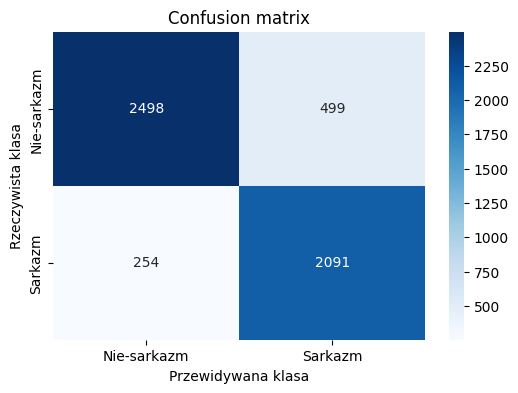

In [11]:
# Uzyskanie prognoz (prawdopodobieństw)
y_pred_prob = bigru_model.predict(X_test_vec)

# Zamiana prawdopodobieństw na klasy: 0 lub 1
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Wyświetlenie raportu klasyfikacji
print("=== Raport klasyfikacji ===")
print(classification_report(y_test, y_pred, target_names=["Nie-sarkazm", "Sarkazm"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Nie-sarkazm", "Sarkazm"],
            yticklabels=["Nie-sarkazm", "Sarkazm"])
plt.xlabel("Przewidywana klasa")
plt.ylabel("Rzeczywista klasa")
plt.title("Confusion matrix")
plt.show()

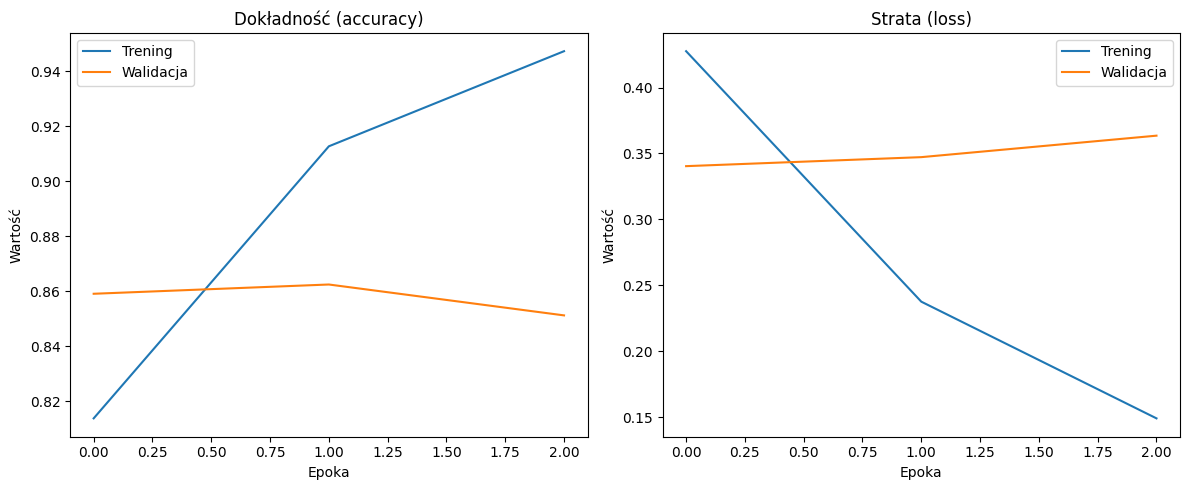

In [12]:
# Krzywe uczenia się

# Wykres dokładności
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Trening')
plt.plot(history.history['val_accuracy'], label='Walidacja')
plt.title('Dokładność (accuracy)')
plt.xlabel('Epoka')
plt.ylabel('Wartość')
plt.legend()

# Wykres straty
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Trening')
plt.plot(history.history['val_loss'], label='Walidacja')
plt.title('Strata (loss)')
plt.xlabel('Epoka')
plt.ylabel('Wartość')
plt.legend()

plt.tight_layout()
plt.show()

Po przeprowadzonej ewaluacji modelu wyciągamy następujące wnioski:

**1. Dokładność i strata (accuracy i loss)**

Na wykresach uczenia widzimy, że:
- Dokładność treningowa rośnie szybko i osiąga ~95% po 3 epokach.
- Dokładność walidacyjna utrzymuje się stabilnie na poziomie ~85-86%, bez wyraźnych spadków, co oznacza, że model nie jest przeuczony.
-Strata walidacyjna wzrasta nieznacznie, co może sugerować początek przeuczenia, ale dzięki zastosowanemu early stopping zatrzymano trening we właściwym momencie.

Stąd model dobrze uczy się danych treningowych i ogólnie radzi sobie bardzo dobrze z danymi testowymi, nie przeucza się zbyt szybko.

**2. Raport klasyfikacji**

Model osiągnął:

- accuracy: 86% (dokładność ogólna),
- f1-score:
   - 0.87 dla „nie-sarkazmu”,
   - 0.85 dla „sarkazmu”

To pokazuje, że klasyfikator radzi sobie dobrze z oboma klasami, nawet jeśli sarkazm jest trudniejszy do wykrycia.

- Precision (sarkazm): 0.81 - 81% przewidywań jako sarkazm było poprawnych.

- Recall (sarkazm): 0.89 - model wykrył 89% wszystkich rzeczywistych przypadków sarkazmu.

Oznacza to, że model skutecznie wychwytuje sarkastyczne wypowiedzi, a jego błędy wynikają głównie z nadwrażliwości -> czasem widzi sarkazm tam, gdzie go nie ma.

**3. Confusion matrix**

- 2498 poprawnie wykrytych „nie-sarkazmów”,
- 2091 poprawnych sarkazmów,
- 499 nie-sarkazmów błędnie sklasyfikowanych jako sarkazm (false positives),
- 254 sarkazmów błędnie jako nie-sarkazmy (false negatives).

Model częściej myli się w kierunku „fałszywego alarmu” (false positive), ale lepiej to niż ignorowanie rzeczywistego sarkazmu, czyli model jest bardziej ostrożny, co może być korzystne przy wykrywaniu ironii.

**Podsumowując:**

- Model działa stabilnie, z bardzo dobrym wynikiem F1-score i wysokim recall.
- Przeuczenie zostało skutecznie ograniczone.
- Klasyfikator dobrze rozróżnia sarkazm i nie-sarkazm, nawet jeśli klasy są nierówne.

# Model 2: BiLSTM + Attention

In [19]:
# Warstwa Attention jako osobna klasa
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()
        self.dense = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # inputs: [batch_size (liczba przypadków naraz), time_steps (długość sekwencji np. 15 słów w zdaniu), hidden_size (liczba cech -> wymiar wektora, który reprezentuje każde słowo w sekwencji)]
        scores = tf.nn.tanh(inputs)
        scores = self.dense(scores)
        weights = tf.nn.softmax(scores, axis=1)
        weighted_output = inputs * weights
        output = tf.reduce_sum(weighted_output, axis=1)
        return output

"""
scores = tf.nn.tanh(inputs):
- Każde słowo jest reprezentowane jako wektor liczb
- Funkcja przypominająca tangens położony na boku (tangens hiperboliczny)
- Nieliniowa funkcja aktywacji, która rzekształca każdą liczbę na zakres od -1 do 1, to pomaga ustabilizować sieć i zapobiega zbyt dużym wagom
- W przeciwieństwie do sigmoid (która daje tylko wartości dodatnie), tanh zwraca też wartości ujemne, co ułatwia uczenie się bardziej zrównoważonych reprezentacji
- Wprowadza nieliniowość -> gdyby wszystkie warstwy były liniowe (np. tylko mnożenia i dodawania), model nie byłby w stanie nauczyć się złożonych zależności. tanh wprowadza zgięcia i załamania w przestrzeni matematycznej

tf.keras.layers.Dense(1):
- Przekształca każdy wektor (czyli każde słowo) w jedną wartość -> tzw. attention score
- Wynik = tensor o kształcie [batch_size, time_steps, 1]
- Każde słowo w zdaniu dostaje „ocenę”, jak bardzo jest ważne

weights = tf.nn.softmax(scores, axis=1):
- Softmax przekształca te „oceny” w prawdopodobieństwa (czyli wagi) -> wszystkie sumują się do 1
- Dla każdego przykładu w batchu osobno, policz softmax po wszystkich słowach w zdaniu, czyli wzdłuż osi time_steps (axis=1)
- Czyli dla każdego zdania wybieramy, które słowa są ważniejsze (większa waga), które mniej (mniejsza)

weighted_output = inputs * weights:
- Mnożymy każde słowo (jego wektor) przez jego wagę z Attention
- To oznacza, że ważniejsze słowa mają większy wpływ, a mniej ważne są „przyciszane”

output = tf.reduce_sum(weighted_output, axis=1):
- Sumujemy wzmocnione wektory po całej sekwencji
- Otrzymujemy 1 wektor dla każdego zdania taki, który reprezentuje jego najważniejsze informacje (wg mechanizmu Attention)

"""


# Budujemy model BiLSTM + Attention

def build_bilstm_attention_model():
    model = tf.keras.Sequential([
        # Embedding: zamienia indeksy słów na wektory liczbowe (rozmiar 128)
        layers.Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=SEQUENCE_LENGTH),

        # Dwukierunkowa warstwa LSTM z dropout wewnętrznym
        layers.Bidirectional(layers.LSTM(
            64,
            return_sequences=True,
            dropout=0.3,              # Dropout na wejściu
            recurrent_dropout=0.2     # Dropout w stanie ukrytym (bardzo ważne!)
        )),

        # BatchNormalization: stabilizuje i przyspiesza uczenie
        layers.BatchNormalization(),

        # Attention
        Attention(),

        # BatchNormalization po Attention
        layers.BatchNormalization(),

        # Dropout - zapobiega przeuczeniu
        layers.Dropout(0.4),

        # Gęsta warstwa z L2 regularizacją
        layers.Dense(
            32,
            activation='relu',
            kernel_regularizer=regularizers.l2(0.01)
        ),

        layers.Dropout(0.3),

        # Wyjście - prawdopodobieństwo sarkazmu
        layers.Dense(1, activation='sigmoid')
    ])

    # Kompilacja
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
        metrics=['accuracy']
    )

    return model

"""
layers.BatchNormalization():
- Normalizuje dane przepływające przez sieć w każdej mini-partii (batchu)
- Celem jest sprawić, żeby dane miały średnią ~= 0 (wartości ujemne i dodatnie się rœónoważą -> są "rozłożone symetrycznie" wokół 0) i odchylenie standardowe ~= 1 (miara, jak daleko liczby są od średniej, miara rozrzutu danych -> std=1 znaczy, że większość danych znajduje się blisko średniej)
- Działa to osobno w każdej epoce i dla każdego batchu

regularizers.l2(0.01):
- "karze" za zbyt duże wagi neuronów przez pomnożenie sumy wag w loss modelu przez odpowiednią wartość lambda
- Jeśli wagi w sieci stają się bardzo duże, sieć przeucza się, czyli "zapamiętuje" dane zamiast uczyć się uogólnienia
- Dzięki zastosowaniu lambda sieć utrzymuje odpowiednio małe wagi

optimizers.RMSprop(learning_rate=1e-3):
- Root Mean Square Propagation
- Algorytm mówiący sieci jak zmieniać wagi podczas uczenia
- Dynamicznie dopasowuje tempo uczenia dla każdej wagi tak, jak Adam, ale Adam łączy mechanizm RMSprop z dodatkowym "momentum", czyli pamiętaniem kierunku uczenia się
- W modelu zamieniono Adam na RMSprop, ponieważ RMSprop lepiej stabilizuje gradienty w modelach sekwencyjnych takich jak BiLSTM + Attention, które są wrażliwe na skoki gradientów w długich sekwencjach

"""

# Tworzenie i trenowanie modelu
bilstm_attention_model = build_bilstm_attention_model()
bilstm_attention_model.summary()

# Trening modelu
history_bilstm = bilstm_attention_model.fit(
    X_train_vec, y_train,
    validation_data=(X_test_vec, y_test),
    epochs=5,
    class_weight=class_weights,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (Attention)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 49s 58ms/step - accuracy: 0.7139 - loss: 0.8737 - val_accuracy: 0.8401 - val_loss: 0.4123
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 37s 55ms/step - accuracy: 0.8682 - loss: 0.3583 - val_accuracy: 0.8585 - val_loss: 0.3449
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.8981 - loss: 0.2754 - val_accuracy: 0.8598 - val_loss: 0.3407
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 39s 53ms/step - accuracy: 0.9127 - loss: 0.2432 - val_accuracy: 0.8527 - val_loss: 0.3522
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.9328 - loss: 0.2012 - val_accuracy: 0.8562 - val_loss: 0.3563


# Ocena modelu BiLSTM + Attention

167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
=== Raport klasyfikacji ===
              precision    recall  f1-score   support

 Nie-sarkazm       0.90      0.84      0.87      2997
     Sarkazm       0.81      0.88      0.85      2345

    accuracy                           0.86      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.86      0.86      0.86      5342



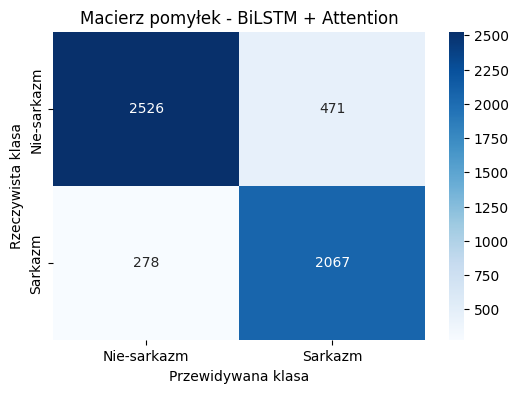

In [20]:
# Uzyskanie prognoz (prawdopodobieństw)
y_pred_prob = bilstm_attention_model.predict(X_test_vec)

# Zamiana prawdopodobieństw na klasy: 0 lub 1
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Raport klasyfikacji
print("=== Raport klasyfikacji ===")
print(classification_report(y_test, y_pred, target_names=["Nie-sarkazm", "Sarkazm"]))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Nie-sarkazm", "Sarkazm"],
            yticklabels=["Nie-sarkazm", "Sarkazm"])
plt.xlabel("Przewidywana klasa")
plt.ylabel("Rzeczywista klasa")
plt.title("Macierz pomyłek - BiLSTM + Attention")
plt.show()

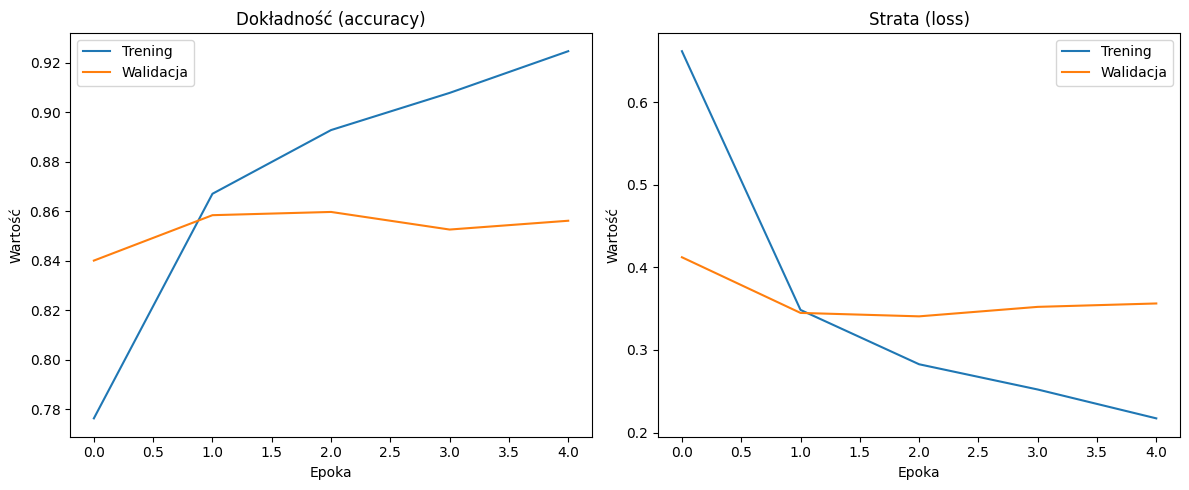

In [21]:
# Wykres dokładności
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bilstm.history['accuracy'], label='Trening')
plt.plot(history_bilstm.history['val_accuracy'], label='Walidacja')
plt.title('Dokładność (accuracy)')
plt.xlabel('Epoka')
plt.ylabel('Wartość')
plt.legend()

# Wykres straty
plt.subplot(1, 2, 2)
plt.plot(history_bilstm.history['loss'], label='Trening')
plt.plot(history_bilstm.history['val_loss'], label='Walidacja')
plt.title('Strata (loss)')
plt.xlabel('Epoka')
plt.ylabel('Wartość')
plt.legend()

plt.tight_layout()
plt.show()

Po przeprowadzonej ewaluacji modelu BiLSTM + Attention wyciągamy następujące wnioski:

**1. Dokładność i strata (accuracy i loss)**

Na wykresach uczenia widzimy, że:

- Dokładność treningowa systematycznie rośnie, osiągając ok. 93% po 5 epokach.
- Dokładność walidacyjna pozostaje stabilna w zakresie 85-86%, co oznacza, że model dobrze generalizuje i nie jest silnie przeuczony.
- Strata walidacyjna utrzymuje się na stabilnym poziomie po początkowym spadku, co pokazuje, że model uczy się w sposób zrównoważony. Dzięki zastosowaniu RMSprop, BatchNormalization i EarlyStopping proces uczenia jest dobrze kontrolowany i nie widać oznak silnego przeuczenia.

Model skutecznie uczy się danych i przenosi wiedzę na dane testowe w sposób stabilny.

**2. Raport klasyfikacji**

Model osiągnął:

- accuracy: 86% — bardzo dobra ogólna dokładność,
- f1-score:
  - 0.87 dla klasy „nie-sarkazm”,
  - 0.85 dla klasy „sarkazm”.

Jest to bardzo dobry wynik — świadczy o tym, że model dobrze radzi sobie z klasyfikacją obu klas, a nie tylko większościowej.

- Precision (sarkazm): 0.81 - 81% przewidywań jako sarkazm było poprawnych.
- Recall (sarkazm): 0.88 - model wykrył aż 88% rzeczywistych przypadków sarkazmu.

Oznacza to, że model skutecznie wychwytuje sarkastyczne wypowiedzi, a jego błędy są zrównoważone, unika zarówno pomijania sarkazmu, jak i nadmiernego przypisywania go tam, gdzie go nie ma.

**3. Confusion matrix**

- 2526 poprawnie wykrytych „nie-sarkazmów”,
- 2067 poprawnie wykrytych sarkazmów,
- 471 nie-sarkazmów błędnie sklasyfikowanych jako sarkazm (false positives),
- 278 sarkazmów błędnie jako nie-sarkazmy (false negatives).

Model lekko preferuje unikanie false negatives (czyli lepiej "nie przegapić" sarkazmu) kosztem nieco większej liczby false positives.
Jest to sensowna strategia przy wykrywaniu sarkazmu, ponieważ wykrycie sarkazmu bywa ważniejsze niż przypadkowe jego przypisanie (lepiej być ostrożnym).

Podsumowując:

- Model BiLSTM + Attention działa bardzo stabilnie, osiągając bardzo dobry wynik F1-score i wysoki recall dla sarkazmu.
- Użycie Attention pozwoliło mu dobrze skupić się na istotnych fragmentach tekstu.
- Wprowadzenie BatchNormalization, Dropout, RMSprop i EarlyStopping poprawiło stabilność i ograniczyło przeuczenie.
- Model radzi sobie świetnie z obydwiema klasami, bez widocznego uprzywilejowania jednej z nich.

W porównaniu do BiGRU, BiLSTM + Attention pokazuje bardziej stabilne uczenie, lepszy recall dla sarkazmu i bardzo dobry balans precyzji i czułości.
Jest to mocny, dobrze dopasowany model do zadania detekcji sarkazmu.

# Podsumowanie

- Oba modele (BiGRU oraz BiLSTM + Attention) osiągnęły bardzo dobre wyniki -> accuracy 86%, wysokie F1-score oraz stabilne procesy uczenia.

- Model BiLSTM + Attention dzięki mechanizmowi Attention lepiej identyfikuje kontekst w tekście i jest mniej podatny na false negatives, co jest szczególnie korzystne w zadaniu detekcji sarkazmu.

- Zastosowanie BatchNormalization, Dropout, RMSprop i EarlyStopping pozwoliło osiągnąć stabilne uczenie i ograniczyć przeuczenie.

**Wnioski końcowe:**

Model BiLSTM + Attention okazał się nieco lepszym i bardziej stabilnym rozwiązaniem w porównaniu do BiGRU, szczególnie pod względem recall i lepszego zbalansowania błędów. Mechanizm Attention pomaga skutecznie skupić się na najistotniejszych fragmentach tekstu, co w przypadku detekcji sarkazmu daje wymierne korzyści.